In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, roc_curve
)
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
X_balanced = pd.read_csv('X_balanced.csv')
y_balanced = pd.read_csv('y_balanced.csv')

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

In [4]:
def sanitize_feature_names(df):
    df = df.copy()
    df.columns = [col.replace(",", "_").replace(" ", "_").replace("[", "_").replace("]", "_") for col in df.columns]
    return df

In [5]:
X_train_sanitized = sanitize_feature_names(X_train)
X_test_sanitized = sanitize_feature_names(X_test)

In [6]:
model_dir = "models"
model_names = [
    "random_forest_best_model",
    "knn_classifier_best_model",
    "lightgbm_best_model",
]

models = {}
for name in model_names:
    path = os.path.join(model_dir, f"{name}.joblib")
    if os.path.exists(path):
        models[name] = joblib.load(path)
    else:
        print(f"⚠️ Model {name} not found!")

In [7]:
voting_clf = VotingClassifier(
    estimators=[
        ("rf", models["random_forest_best_model"]),
        ("knn", models["knn_classifier_best_model"]),
        ("lgbm", models["lightgbm_best_model"])
    ],
    voting="soft",
    n_jobs=-1
)

stacking_clf = StackingClassifier(
    estimators=[
        ("rf", models["random_forest_best_model"]),
        ("knn", models["knn_classifier_best_model"])
    ],
    final_estimator=LogisticRegression(),
    passthrough=True,
    n_jobs=-1
)

In [8]:
results = {}

def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba)
    except:
        y_proba = None
        roc_auc = None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    results[name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "ROC AUC": roc_auc
    }

    print(f"\n📊 Evaluation for {name}")
    print("-" * 40)
    print(classification_report(y_test, y_pred, zero_division=0))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    if y_proba is not None:
        print(f"ROC AUC Score: {roc_auc:.4f}")
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
        plt.plot([0, 1], [0, 1], "k--")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.title(f"ROC Curve - {name}")
        plt.legend()
        plt.grid(True)
        os.makedirs("plots", exist_ok=True)
        plt.savefig(f"plots/roc_curve_{name.replace(' ', '_').lower()}.png")
        plt.close()
        print(f"📈 ROC Curve saved as plots/roc_curve_{name.replace(' ', '_').lower()}.png")

In [9]:
# Train and evaluate
for model, name in [(voting_clf, "Voting Ensemble"), (stacking_clf, "Stacking Ensemble")]:
    print(f"\n🚀 Training {name}...")
    model.fit(X_train_sanitized, y_train)
    evaluate_model(model, X_test, y_test, name)
    joblib.dump(model, f"models/{name.replace(' ', '_').lower()}_model.joblib")


🚀 Training Voting Ensemble...


c:\Users\Aavash\miniconda3\envs\assign-ml\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Aavash\miniconda3\envs\assign-ml\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)



📊 Evaluation for Voting Ensemble
----------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     11230
           1       0.98      0.95      0.97     11230

    accuracy                           0.97     22460
   macro avg       0.97      0.97      0.97     22460
weighted avg       0.97      0.97      0.97     22460

Confusion Matrix:
[[11056   174]
 [  547 10683]]
ROC AUC Score: 0.9978
📈 ROC Curve saved as plots/roc_curve_voting_ensemble.png

🚀 Training Stacking Ensemble...


c:\Users\Aavash\miniconda3\envs\assign-ml\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Aavash\miniconda3\envs\assign-ml\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)



📊 Evaluation for Stacking Ensemble
----------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     11230
           1       0.98      0.98      0.98     11230

    accuracy                           0.98     22460
   macro avg       0.98      0.98      0.98     22460
weighted avg       0.98      0.98      0.98     22460

Confusion Matrix:
[[11006   224]
 [  228 11002]]
ROC AUC Score: 0.9985
📈 ROC Curve saved as plots/roc_curve_stacking_ensemble.png


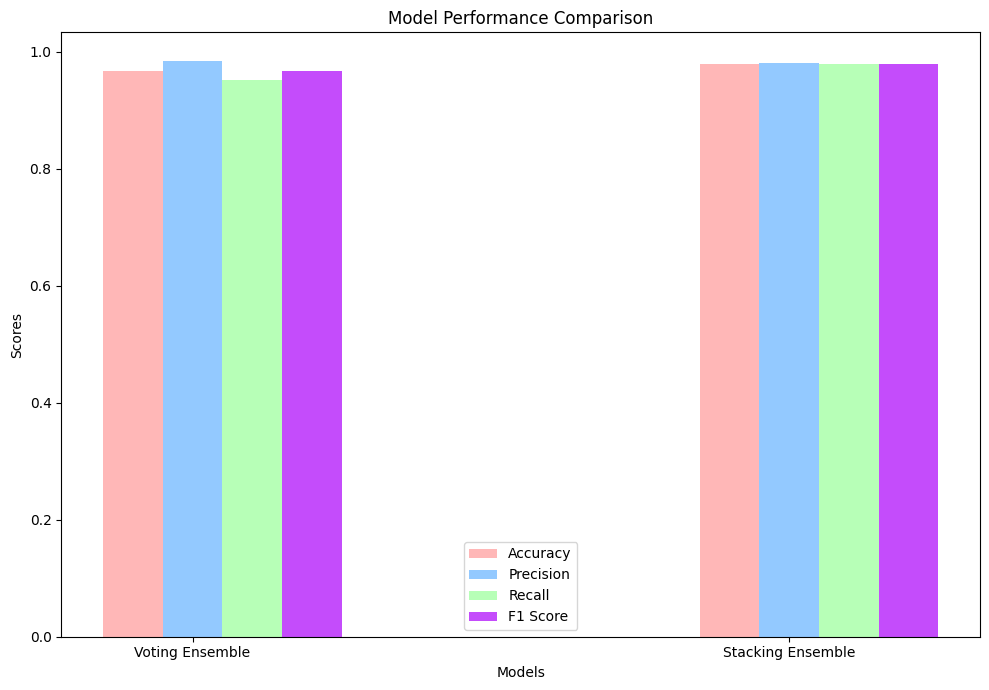

In [10]:
plt.figure(figsize=(10, 7))
x = np.arange(len(results))
width = 0.1

metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
colors = ["#FF9999", "#66B3FF", "#99FF99", "#AB00FA"]

for i, (metric, color) in enumerate(zip(metrics, colors)):
    plt.bar(
        x + i * width,
        [results[model][metric] for model in results],
        width=width,
        label=metric,
        color=color,
        alpha=0.7
    )

plt.xlabel("Models")
plt.ylabel("Scores")
plt.title("Model Performance Comparison")
plt.xticks(x + width, results.keys())
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
import json

print(json.dumps(results, indent=2, default=str))

{
  "Voting Ensemble": {
    "Accuracy": 0.9678984861976848,
    "Precision": 0.9839734733351755,
    "Recall": 0.9512911843276937,
    "F1 Score": 0.9673563634717255,
    "ROC AUC": 0.9977522204310584
  },
  "Stacking Ensemble": {
    "Accuracy": 0.9798753339269813,
    "Precision": 0.9800463210404419,
    "Recall": 0.9796972395369545,
    "F1 Score": 0.9798717491984325,
    "ROC AUC": 0.9985292146957212
  }
}
